In [14]:
PATH_TO_BHPTNRSur = "/home/ubuntu/EG-CA/BHPTNRSurrogate"
import numpy as np
import matplotlib.pyplot as plt
import sys
# add the path to the script directory
sys.path.append(PATH_TO_BHPTNRSur)
from surrogates import BHPTNRSur1dq1e4 as bhptsur

(7.333948118743882e-22+7.212079186780542e-32j)


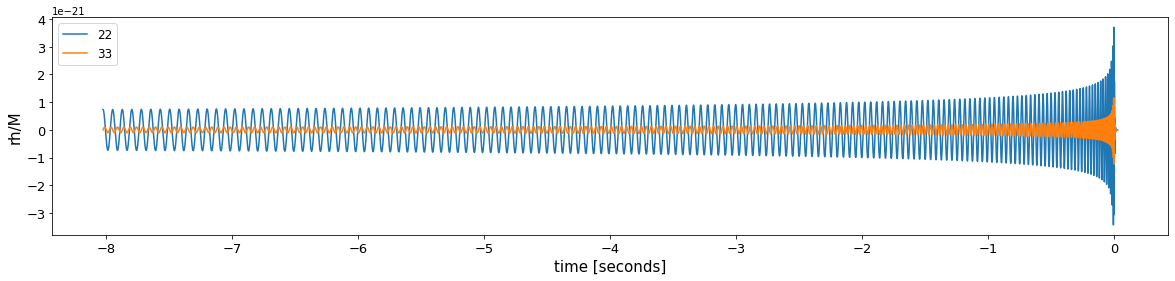

In [43]:
tsur, hsur = bhptsur.generate_surrogate(q=10, M_tot=60, dist_mpc=100)
print(hsur[(2,2)][0])

#print(hsur.keys())

plt.figure(figsize=(20,4))
plt.plot(tsur, np.real(hsur[(2,2)]), '-', label='22')
plt.plot(tsur, np.real(hsur[(3,3)]), '-', label='33')
plt.xlabel('time [seconds]', fontsize=15)
plt.ylabel('rh/M', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=12)
plt.show()